# WAV TO MIDI TRANSCRIPTION
### 1. Provided with dataset of synced MIDI + WAV files, cut each performance's spectrogram into many slices (in this case 0.12 seconds)
### 2. Find from MIDI which keys are pressed during that slice
### 3. Pack into spectrogram + pressed input
### 4. Train CNN to take in spectrogram into pressed input
### 5. Stitch together slices into a MIDI file

# Imports

In [1]:
import csv
import mido
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import sys
from PIL import Image


MAESTRO_CSV = "../MAESTRO_Dataset/maestro-v3.0.0.csv"
MAESTRO_PATH = "../MAESTRO_Dataset/maestro-v3.0.0/"
PAIN_PATH = "./PAIN_Dataset/"

In [2]:
config = {
    "timestep": 5,
    "sample_rate": 16000,
    "num_notes": 88,
    "start_note": 21,
    "hop_size": 384,
    "device": "cuda",
}

# Dataset, Dataloader

In [3]:
class MAESTRODataset(Dataset):
    def __init__(self, split):
        self.csv_metadata = {"canonical_composer": [], "canonical_title": [], "split": [
        ], "year": [], "midi_filename": [], "audio_filename": [], "duration": []}

        with open(MAESTRO_CSV, "r", encoding="utf8") as f:
            reader = csv.reader(f, delimiter=",")
            lines = list(reader)

            for row in lines[1:]:  # Skip header
                if row[2] != split:
                    continue
                self.csv_metadata["canonical_composer"].append(row[0])
                self.csv_metadata["canonical_title"].append(row[1])
                self.csv_metadata["split"].append(row[2])
                self.csv_metadata["year"].append(row[3])
                self.csv_metadata["midi_filename"].append(row[4])
                self.csv_metadata["audio_filename"].append(row[5])
                self.csv_metadata["duration"].append(row[6])
        
    
    def __len__(self):
        return len(self.csv_metadata["midi_filename"])
    
    def __getitem__(self, idx):
        can_composer = self.csv_metadata["canonical_composer"][idx]
        can_title = self.csv_metadata["canonical_title"][idx]
        split = self.csv_metadata["split"][idx]
        year = self.csv_metadata["year"][idx]
        midi_filename = self.csv_metadata["midi_filename"][idx]
        audio_filename = self.csv_metadata["audio_filename"][idx]
        duration = self.csv_metadata["duration"][idx]
        return (can_composer, can_title, split, year, midi_filename, audio_filename, duration)


# Piano Audio INstrumentation (PAIN)
### Data Generation

In [4]:
def wav_to_logmel(wav, sample_rate, win_size, hop_length, n_mels, fmin=50, fmax=8000, window_fn=torch.hann_window):
    mel_spectrogram = MelSpectrogram(sample_rate, win_size, hop_length=hop_length, f_min=fmin, f_max=fmax, n_mels=n_mels, power=2, window_fn=window_fn)
    amplitude_to_db = AmplitudeToDB(stype="power", top_db=80)
    mel_spectrogram(torch.zeros(1, win_size * 10))
    mel = mel_spectrogram(wav)
    logmel = amplitude_to_db(mel)
    return logmel

def read_wav(wav_path):
    wave, sr = torchaudio.load(wav_path, normalize=True)
    resampler = torchaudio.transforms.Resample(sr, config["sample_rate"])
    wave = wave.mean(dim=0)
    wave = resampler(wave)
    logmel = wav_to_logmel(wave, config["sample_rate"], 2048, config["hop_size"], 229, fmin=50, fmax=8000, window_fn=torch.hann_window).numpy().T

    combined_logmel = np.zeros((np.shape(logmel)[0] // config["timestep"], config["timestep"], np.shape(logmel)[1]), dtype=np.float32)

    for j in range(np.shape(combined_logmel)[0]):
        combined_logmel[j] = logmel[j * config["timestep"]:(j + 1) * config["timestep"]]

    return combined_logmel


def track_to_sequence(track):
    sequence = []
    sequence.append([0] * 88)

    for msg in track:
        for _ in range(msg.time):
            sequence.append(sequence[-1].copy())

        if msg.type == "note_on":
            if msg.velocity > 0:
                sequence[-1][msg.note - 21] = 1
            else:
                sequence[-1][msg.note - 21] = 0

    return sequence[1:]


def read_midi(midi_path):
    midi_file = mido.MidiFile(midi_path)
    ticks_per_beat = midi_file.ticks_per_beat
    tempo = 500000  # Default value
    if len(midi_file.tracks) != 2:
        seq = track_to_sequence(midi_file.tracks[0])
    else:
        seq = track_to_sequence(midi_file.tracks[1])

    time_quant = config["hop_size"] / config["sample_rate"] * config["timestep"]
    time_quant_to_tick = mido.second2tick(time_quant, ticks_per_beat, tempo)
    
    # Combine time_quant_to_tick ticks of piano rolls into one roll that shows all notes played in that time_quant_to_tick

    combined = np.zeros((int(np.shape(seq)[0] // time_quant_to_tick), 88))
    for i in range(np.shape(combined)[0]):
        combined[i] = np.any(seq[int(i * time_quant_to_tick):int((i + 1) * time_quant_to_tick)], axis=0)

        
    return combined


In [5]:
def gen_pain(dataloader):
    for i, (can_composer, can_title, split, year, midi_filename, audio_filename, duration) in tqdm(enumerate(dataloader), desc="MAESTRO", position=0):
        if split[0] == "train":
            if (len(os.listdir(PAIN_PATH + split[0])) > 100000):
                break
        else:
            if (len(os.listdir(PAIN_PATH + split[0])) > 10000):
                break
            
        if float(duration[0]) > 200:
            continue
            
        # Preprocess audio
        combined_logmel = read_wav(MAESTRO_PATH + audio_filename[0])

        combined_roll = read_midi(MAESTRO_PATH + midi_filename[0])

        for j in tqdm(range(np.shape(combined_roll)[0]), desc="Generating spectrograms...", position=1):
            # Save log mel spectrogram
            figname = f"{i}-{j}-" + np.array2string(np.where(combined_roll[j] == 1)[0], max_line_width=256, separator=",")

            plt.imsave(PAIN_PATH + split[0] + f"/{figname}.png", combined_logmel[j].T, cmap="magma")


In [6]:
test_m_dataset = MAESTRODataset(split="test")
test_m_dataloader = DataLoader(test_m_dataset, batch_size=1, shuffle=False, num_workers=0)
gen_pain(test_m_dataloader)


MAESTRO: 0it [00:00, ?it/s]


In [7]:
validation_m_dataset = MAESTRODataset(split="validation")
validation_m_dataloader = DataLoader(validation_m_dataset, batch_size=1, shuffle=True, num_workers=0)
gen_pain(validation_m_dataloader)

MAESTRO: 0it [00:00, ?it/s]


In [8]:
train_m_dataset = MAESTRODataset(split="train")
train_m_dataloader = DataLoader(train_m_dataset, batch_size=1, shuffle=True, num_workers=0)
gen_pain(train_m_dataloader)

MAESTRO: 0it [00:00, ?it/s]


In [9]:
class PAINDataset(Dataset):
    def __init__(self, split):
        self.images = os.listdir(PAIN_PATH + split)
        self.split = split
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get label from image name
        label = np.zeros((88), dtype=np.float32)
        chosen_indexes = eval(self.images[idx].split("-")[2][:-4])
        for index in chosen_indexes:
            label[index] = 1
        
        # Convert image to tensor
        image = Image.open(PAIN_PATH + self.split + "/" + self.images[idx])
        image = transforms.ToTensor()(image)
        
        # Discard alpha channel
        image = image[:3]
        
        return image, label
        

c:\Users\W\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


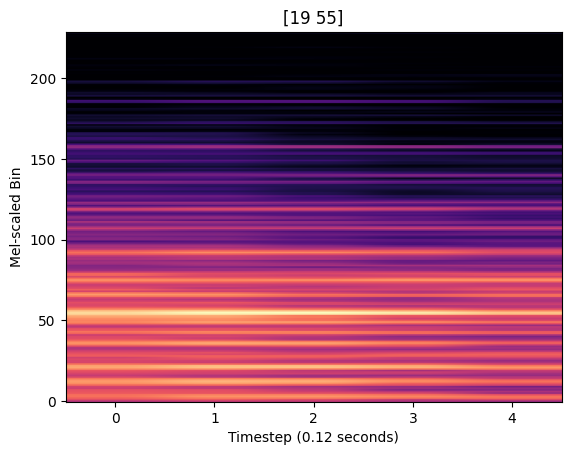

In [10]:
pain_dataset = PAINDataset("train")
pain_dataloader = DataLoader(pain_dataset, batch_size=1, shuffle=True, num_workers=0)

for i, (image, label) in enumerate(pain_dataloader):
    # print(np.shape(image))
    # print(np.shape(label))

    plt.title(np.where(label[0] == 1)[0])
    plt.ylabel("Mel-scaled Bin")
    plt.xlabel("Timestep (0.12 seconds)")
    plt.imshow(image[0].permute(1, 2, 0), cmap="magma", aspect='auto', origin='lower')
    print()
    break


# CNN Setup

In [11]:
class TranscriptCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(TranscriptCNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size

        # Input shape is (3, 1145)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.lin1 = nn.Linear(64 * 229 * 5, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print(np.shape(x))
        x = x.view(-1, 3, 229, 5)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        #print(np.shape(x))
        x = x.view(-1, 64 * 229 * 5)
        x = self.lin1(x)
        x = self.sigmoid(x)

        return x


# Training

In [19]:
pain_dataset = PAINDataset("train")
pain_dataloader = DataLoader(pain_dataset, batch_size=32, shuffle=True, num_workers=0)

test_model = TranscriptCNN(1145, 88).to(config['device'])
loss_func = nn.BCELoss()
optimizer = optim.Adam(test_model.parameters(), lr=1e-4)

losses = []
num_epochs = 5
update_interval = 10

for j in range(num_epochs):
    for i, (image, label) in tqdm(enumerate(pain_dataloader)):        
        test_input = image.to(config['device'])
        test_label = label.to(config['device'])

        optimizer.zero_grad()

        output = test_model(test_input)

        loss = loss_func(output, test_label)
        
        if i % update_interval == 0:
            losses.append(loss.item())

        loss.backward()

        optimizer.step()


3154it [08:55,  5.89it/s]
3154it [02:15, 23.35it/s]
3154it [01:17, 40.56it/s]
3154it [01:08, 45.77it/s]
3154it [01:09, 45.23it/s]


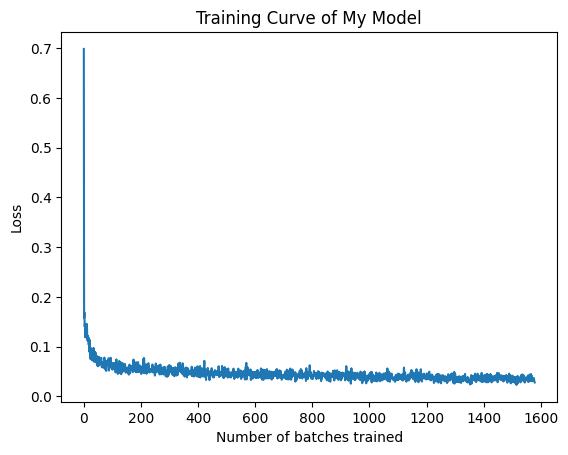

In [20]:
# Plot losses with title and axis labels
plt.title("Training Curve of My Model")
plt.xlabel("Number of batches trained")
plt.ylabel("Loss")
plt.plot(losses)


In [35]:
# Save model
torch.save(test_model.state_dict(), "./model/transcript_cnn.pt")

In [12]:
# Load model with torch.load()
test_model = TranscriptCNN(1145, 88).to(config['device'])
test_model.load_state_dict(torch.load("./model/transcript_cnn.pt"))

<All keys matched successfully>

356it [00:55,  6.46it/s]


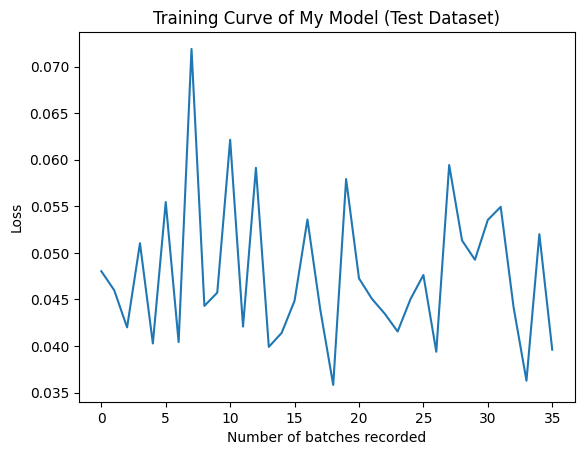

In [39]:
# Test loss on test dataset
pain_test_dataset = PAINDataset("test")
pain_test_dataloader = DataLoader(pain_test_dataset, batch_size=32, shuffle=True, num_workers=0)

validate_losses = []
for i, (image, label) in tqdm(enumerate(pain_test_dataloader)):
    test_input = image.to(config['device'])
    test_label = label.to(config['device'])

    output = test_model(test_input)

    loss = loss_func(output, test_label)
    if i % update_interval == 0:
        validate_losses.append(loss.item())

plt.title("Training Curve of My Model (Test Dataset)")
plt.xlabel("Number of batches recorded")
plt.ylabel("Loss")
plt.plot(validate_losses)


333it [00:44,  7.42it/s]


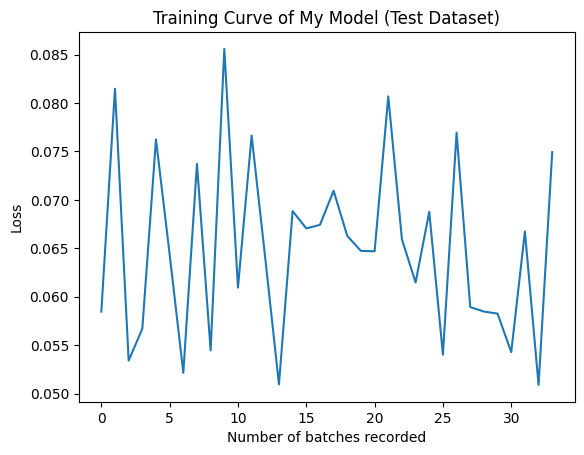

In [60]:
loss_func = nn.BCELoss()
update_interval = 10
# Test loss on test dataset
pain_validate_dataset = PAINDataset("validation")
pain_validate_dataloader = DataLoader(pain_validate_dataset, batch_size=32, shuffle=True, num_workers=0)

validate_losses = []
for i, (image, label) in tqdm(enumerate(pain_validate_dataloader)):
    test_input = image.to(config['device'])
    test_label = label.to(config['device'])

    output = test_model(test_input)

    loss = loss_func(output, test_label)
    if i % update_interval == 0:
        validate_losses.append(loss.item())

plt.title("Training Curve of My Model (Validation Dataset)")
plt.xlabel("Number of batches recorded")
plt.ylabel("Loss")
plt.plot(validate_losses)


# Test on unseen data

In [40]:
shortest_audio = None
shortest_audio_dur = 100000.
shortest_midi = None

for i, (can_composer, can_title, split, year, midi_filename, audio_filename, duration) in tqdm(enumerate(validation_m_dataloader), desc="MAESTRO", position=0):
    #if float(duration[0]) < shortest_audio_dur:
    if float(duration[0]) < 150:
        print(can_composer[0])
        print(can_title[0])
        print(split[0])
        print(year[0])
        print(midi_filename[0])
        print(audio_filename[0])
        print(duration[0])
        break
        



MAESTRO: 0it [00:00, ?it/s]

Frédéric Chopin
Mazurka in F Minor, Op. 7, No. 3
validation
2014
2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--5.midi
2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--5.wav
121.519643437


In [40]:
# Generate test input
# test0 wav = 2011/MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_09_Track09_wav.wav
# test1 wav = 2011/MIDI-Unprocessed_21_R1_2011_MID--AUDIO_R1-D8_09_Track09_wav.wav
# test2 wav = 2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--3
# test3 av = 2017/MIDI-Unprocessed_062_PIANO062_MID--AUDIO-split_07-07-17_Piano-e_2-07_wav--3
test_combined_logmel = read_wav("./testing/custom1.wav")
# test_combined_roll = read_midi("./testing/test.midi")

# print(np.shape(test_combined_logmel), np.shape(test_combined_roll))

for file in os.listdir("./testing/dataset"):
    os.remove("./testing/dataset/" + file)
for j in tqdm(range(np.shape(test_combined_logmel)[0]), desc="Generating spectrograms...", position=0):
    figname = f"{j}-"
    plt.imsave("./testing/dataset" + f"/{figname}.png", test_combined_logmel[j].T, cmap="magma")

# Get output from model
test_output_roll = np.zeros((np.shape(test_combined_logmel)[0], 88))
inputs = os.listdir("./testing/dataset")
# sort input by first number before "-"
inputs = sorted(inputs, key=lambda x: int(x.split("-")[0]))
for i, inp in enumerate(inputs):
    # print inp
    #print(inp)
    
    # Convert image to tensor
    image = Image.open("./testing/dataset/" + inp)
    image = transforms.ToTensor()(image)

    # Discard alpha channel
    image = image[:3].to(config['device'])
    
    # Get output
    output = test_model(image)
    
    # Add to output roll
    det = output.cpu().detach().numpy()
    # Convert to binary
    #det[det > 0] = 1
    test_output_roll[i] = det[0]

Generating spectrograms...: 100%|██████████| 498/498 [00:01<00:00, 485.87it/s]


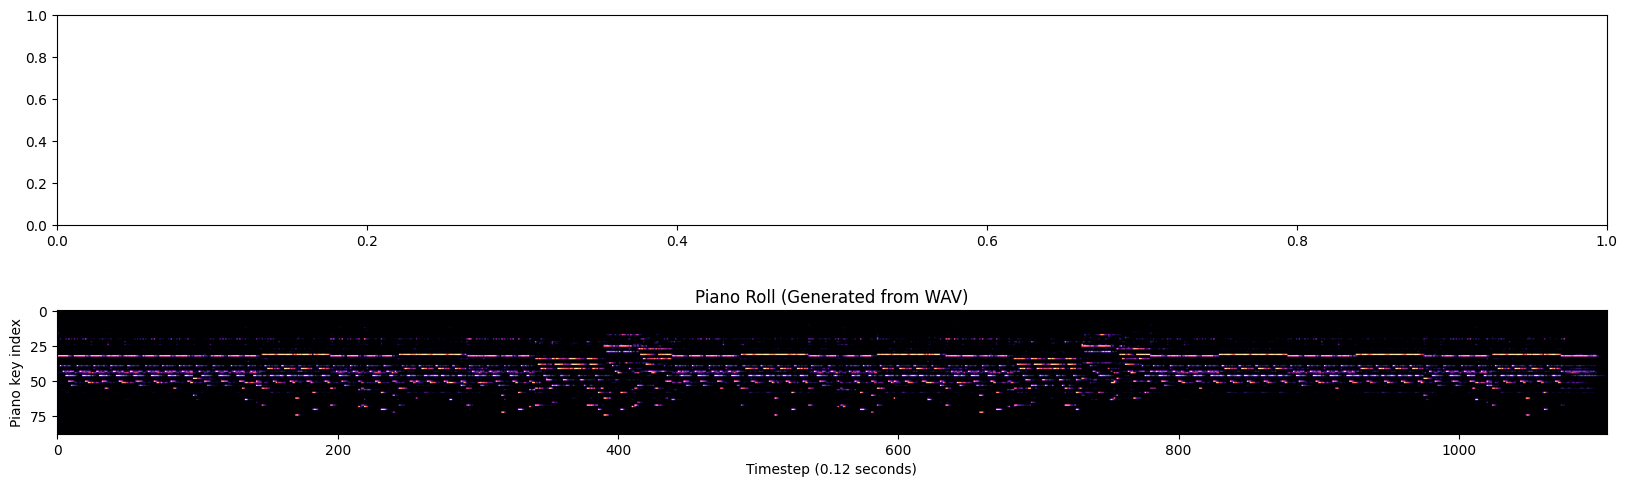

In [15]:
f, ax = plt.subplots(2, 1, figsize=(20, 6))
# Label title
ax[1].set_title("Piano Roll (Generated from WAV)")
ax[1].set(xlabel="Timestep (0.12 seconds)", ylabel="Piano key index")
ax[1].imshow(test_output_roll.T, cmap="magma")


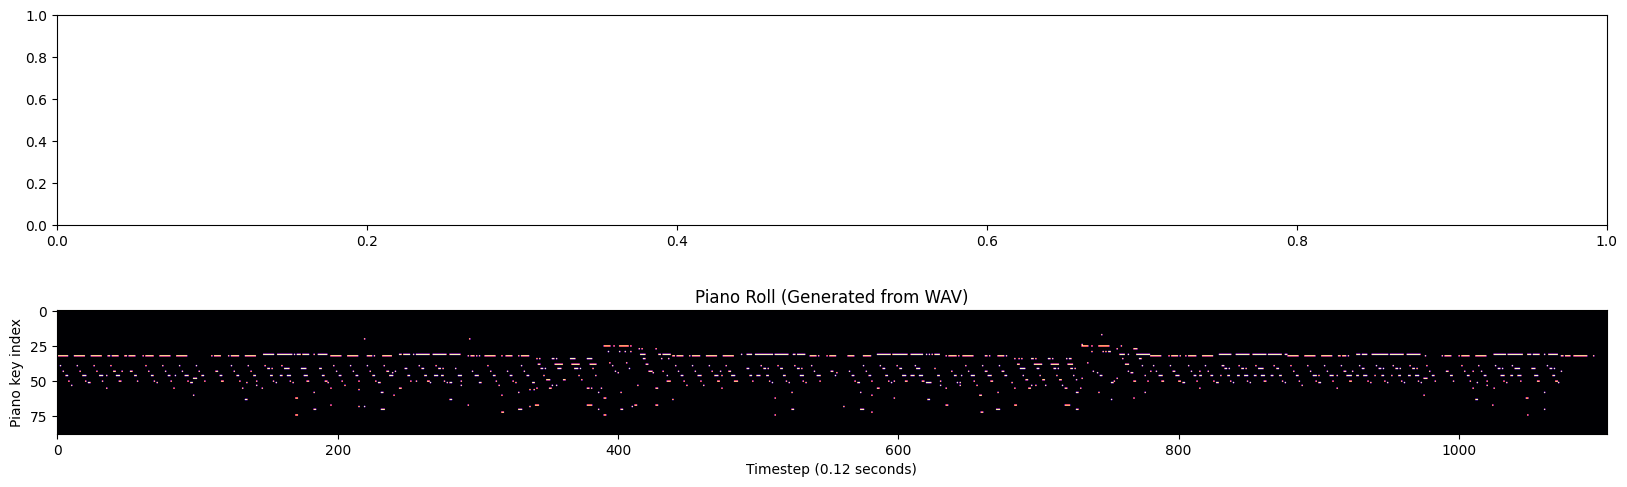

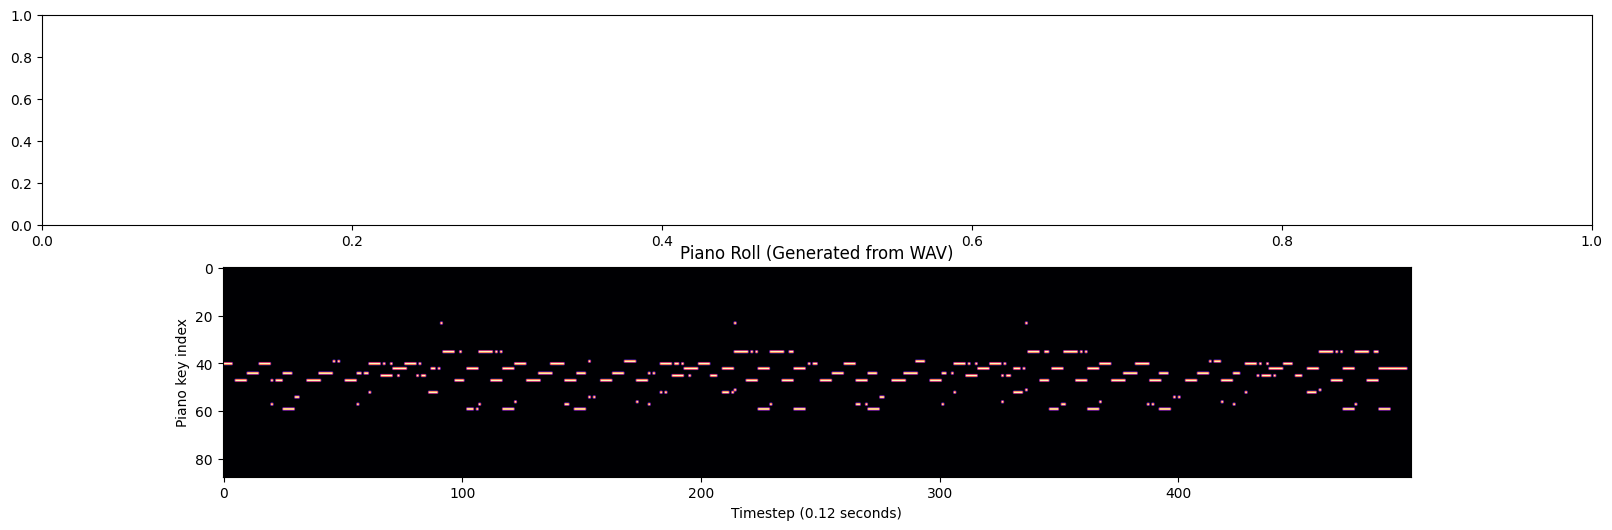

In [43]:
# make modified roll binarize
modified_roll = np.zeros((np.shape(test_combined_logmel)[0], 88))
for i in range(np.shape(test_combined_logmel)[0]):
    modified_roll[i] = np.where(test_output_roll[i] > 0.85, 1, 0)


f, ax = plt.subplots(2, 1, figsize=(20, 6))
# Label title
# ax[0].set_title("Piano Roll (Ground Truth)")
# ax[0].set(xlabel="Timestep (0.12 seconds)", ylabel="Piano key index")
# ax[0].imshow(test_combined_roll[:200].T, cmap="magma")
ax[1].set_title("Piano Roll (Generated from WAV)")
ax[1].set(xlabel="Timestep (0.12 seconds)", ylabel="Piano key index")
ax[1].imshow(modified_roll.T, cmap="magma")

# Generate a MIDI file from the piano roll
def stop_note(note, time):
    return mido.Message('note_off', note=note,
                   velocity=0, time=time)


def start_note(note, time):
    return mido.Message('note_on', note=note,
                   velocity=64, time=time)


def roll_to_track(roll):
    track = []
    delta = 0
    last_state = np.zeros(88)
    
    #1st preprocess: convert 1, 0, 1 to 1, 1, 1
    for i in range(0, np.shape(roll)[0] - 2):
        for j in range(88):
            if roll[i, j] == 1 and roll[i+1, j] == 0 and roll[i+2, j] == 1:
                roll[i, j] = 1
                roll[i+1, j] = 1
                roll[i+2, j] = 1
    
    for row in roll:
        for i, note in enumerate(row):
            if note == 1 and last_state[i] == 0:
                track.append(start_note(i+21, delta))
                delta = 0
            elif note == 0 and last_state[i] == 1:
                track.append(stop_note(i+21, delta))
                delta = 0
                
            last_state[i] = note

        delta += 120
        
    return track

export_midi = mido.MidiFile(type=1)
export_midi.tracks.append(mido.MidiTrack([]))
export_midi.tracks.append(mido.MidiTrack(roll_to_track(modified_roll)))
export_midi.save('output.mid')
